# EN160 Assignment 2 on Fitting and Alignment # 

# Simple blob detection 


(-0.5, 359.5, 359.5, -0.5)

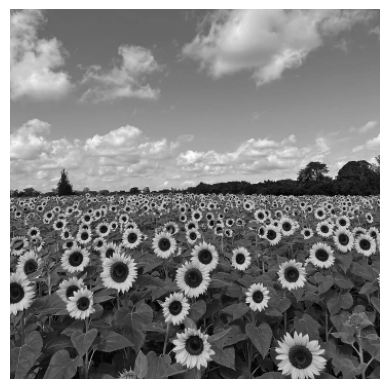

In [1]:
import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Load and convert the image
im = cv2.imread('images/the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY).astype(np.float32)

#show the image
plt.imshow(im_gray, cmap='gray')
plt.axis('off')

In [2]:
%pip install tikzplotlib

Note: you may need to restart the kernel to use updated packages.


Image shape: (360, 360, 3)
Grayscale shape: (360, 360)
Building scale space with 10 scales...
Processing sigma = 1.00 (1/10)
Processing sigma = 1.46 (2/10)
Processing sigma = 2.13 (3/10)
Processing sigma = 3.11 (4/10)
Processing sigma = 4.53 (5/10)
Processing sigma = 6.62 (6/10)
Processing sigma = 9.65 (7/10)
Processing sigma = 14.09 (8/10)
Processing sigma = 20.56 (9/10)
Processing sigma = 30.00 (10/10)
Finding scale-space extrema...
Detected 196 blobs

RESULTS

Sigma range used: [1.00, 30.00]
Number of sigma values: 10

Total blobs detected: 196

--- Top 10 Largest Circles ---
1. Center: (293, 170), Sigma: 14.09, Radius: 19.92, Response: 0.2361
2. Center: (338, 166), Sigma: 14.09, Radius: 19.92, Response: 0.2443
3. Center: (106, 255), Sigma: 6.62, Radius: 9.36, Response: 0.3443
4. Center: (333, 155), Sigma: 6.62, Radius: 9.36, Response: 0.2002
5. Center: (53, 174), Sigma: 6.62, Radius: 9.36, Response: 0.2906
6. Center: (253, 174), Sigma: 6.62, Radius: 9.36, Response: 0.2396
7. Center

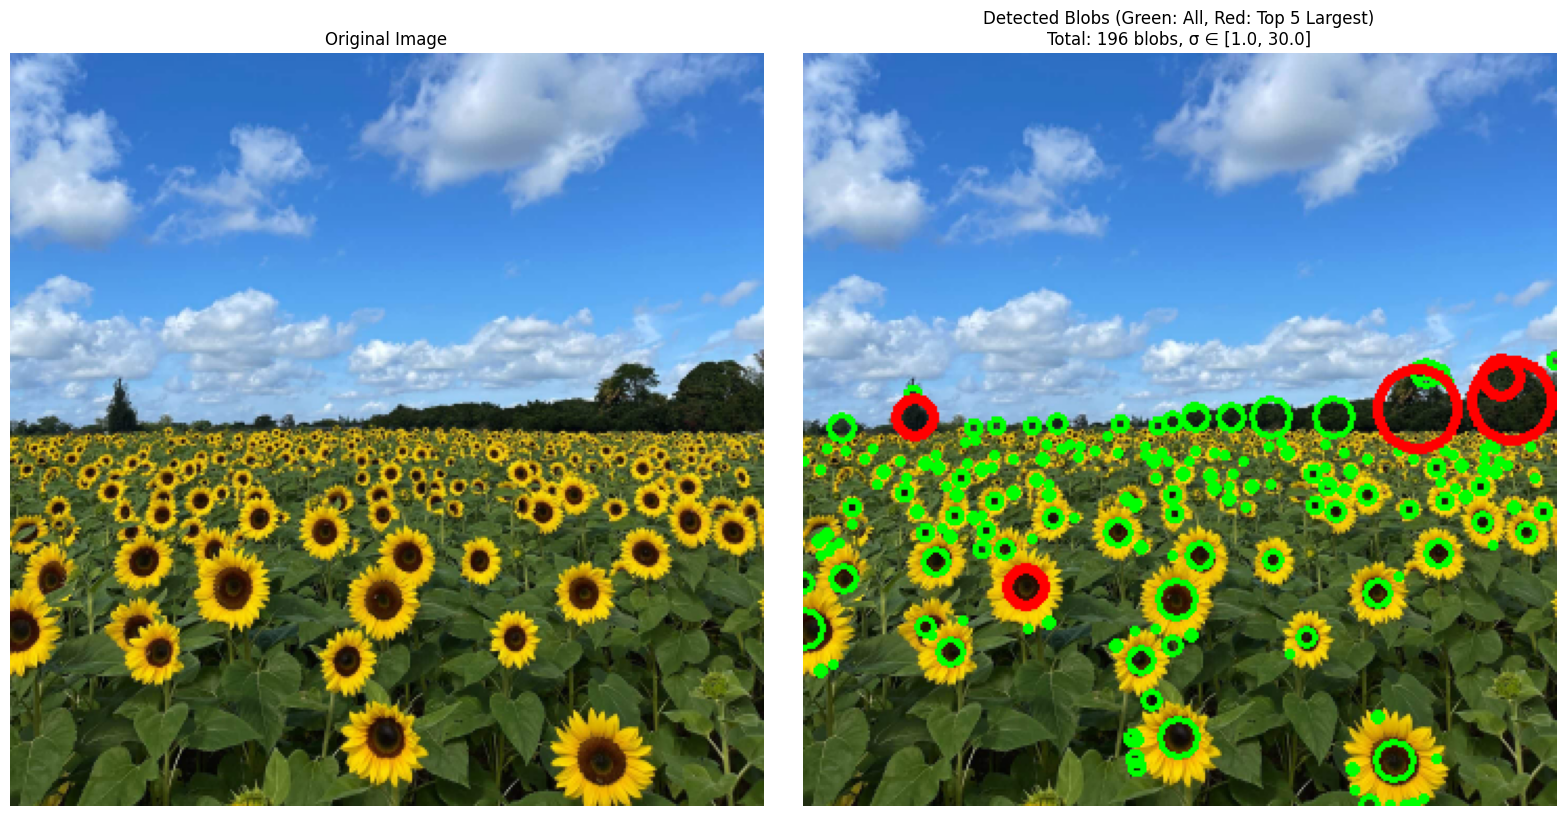


Visualization saved as 'sunflower_blob_detection_result.png'


In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def compute_log_response(image, sigma):
    laplacian_of_gaussian = ndimage.gaussian_laplace(image, sigma)
    return sigma**2 * laplacian_of_gaussian

def detect_blobs_log(image, sigma_min=5, sigma_max=50, num_sigma=20, threshold=0.01):
    """
    Detect blobs using Laplacian of Gaussian across multiple scales.
    
    Parameters:
    - image: grayscale input image
    - sigma_min: minimum sigma value
    - sigma_max: maximum sigma value
    - num_sigma: number of sigma values to test
    - threshold: threshold for blob detection (relative to max response)
    
    Returns:
    - blobs: array of detected blobs (y, x, sigma)
    """
    # Generate sigma values (logarithmic spacing works well)
    sigma_values = np.logspace(np.log10(sigma_min), np.log10(sigma_max), num_sigma)
    
    # Normalize image to [0, 1]
    image_normalized = image.astype(np.float64) / 255.0
    
    # Build scale space
    print(f"Building scale space with {num_sigma} scales...")
    scale_space = np.zeros((len(sigma_values), image.shape[0], image.shape[1]))
    
    for i, sigma in enumerate(sigma_values):
        print(f"Processing sigma = {sigma:.2f} ({i+1}/{num_sigma})")
        scale_space[i] = compute_log_response(image_normalized, sigma)
    
    # Find local maxima in scale space
    print("Finding scale-space extrema...")
    
    # Compute absolute threshold
    abs_threshold = threshold * np.max(scale_space)
    
    # Find local maxima using maximum filter
    # A point is a local maximum if it equals the maximum in its neighborhood
    local_max = ndimage.maximum_filter(scale_space, size=(3, 3, 3))
    detected_blobs = (scale_space == local_max) & (scale_space > abs_threshold)
    
    # Extract blob coordinates
    blobs_indices = np.argwhere(detected_blobs)
    
    blobs = []
    for idx in blobs_indices:
        sigma_idx, y, x = idx
        sigma = sigma_values[sigma_idx]
        response = scale_space[sigma_idx, y, x]
        blobs.append([y, x, sigma, response])
    
    blobs = np.array(blobs)
    print(f"Detected {len(blobs)} blobs")
    
    return blobs, sigma_values

def draw_circles(image, blobs, color=(0, 255, 0), thickness=2):
    """
    Draw circles on the image based on detected blobs.
    The radius is sqrt(2) * sigma for LoG blobs.
    """
    output = image.copy()
    
    for blob in blobs:
        y, x, sigma = blob[:3]
        # Radius for LoG blob is sqrt(2) * sigma
        radius = int(np.sqrt(2) * sigma)
        cv.circle(output, (int(x), int(y)), radius, color, thickness)
    
    return output

# Load the image
im = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

if im is None:
    print("Error: Could not load image. Please check the path.")
else:
    # Convert to grayscale
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    print(f"Image shape: {im.shape}")
    print(f"Grayscale shape: {gray.shape}")
    
    # Detect blobs using LoG
    # Adjust these parameters based on expected sunflower sizes
    blobs, sigma_values = detect_blobs_log(
        gray,
        sigma_min=1,      # Minimum sigma
        sigma_max=30,     # Maximum sigma
        num_sigma=10,     # Number of scales to test
        threshold=0.5 # Detection threshold (lower = more detections)
    )
    
    # Sort blobs by size (sigma) in descending order
    blobs_sorted = blobs[np.argsort(blobs[:, 2])[::-1]]
    
    # Report largest circles
    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)
    print(f"\nSigma range used: [{sigma_values[0]:.2f}, {sigma_values[-1]:.2f}]")
    print(f"Number of sigma values: {len(sigma_values)}")
    print(f"\nTotal blobs detected: {len(blobs)}")
    
    print("\n--- Top 10 Largest Circles ---")
    for i, blob in enumerate(blobs_sorted[:10]):
        y, x, sigma, response = blob
        radius = np.sqrt(2) * sigma
        print(f"{i+1}. Center: ({int(x)}, {int(y)}), Sigma: {sigma:.2f}, "
              f"Radius: {radius:.2f}, Response: {response:.4f}")
    
    # Draw all detected circles
    result = draw_circles(im, blobs, color=(0, 255, 0), thickness=2)
    
    # Draw top 5 largest circles in red for visibility
    result = draw_circles(result, blobs_sorted[:5], color=(0, 0, 255), thickness=3)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original image
    axes[0].imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Result with detected circles
    axes[1].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
    axes[1].set_title(f'Detected Blobs (Green: All, Red: Top 5 Largest)\n'
                      f'Total: {len(blobs)} blobs, σ ∈ [{sigma_values[0]:.1f}, {sigma_values[-1]:.1f}]')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('sunflower_blob_detection_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("Visualization saved as 'sunflower_blob_detection_result.png'")
    print("="*60)

Fitting line using RANSAC...
Line parameters [a, b, d]: [0.70796352 0.70624901 1.11978491]
Number of line inliers: 46

Fitting circle using RANSAC...
Circle parameters [x0, y0, r]: [ 1.98088134  3.00892844 10.02865655]
Number of circle inliers: 47


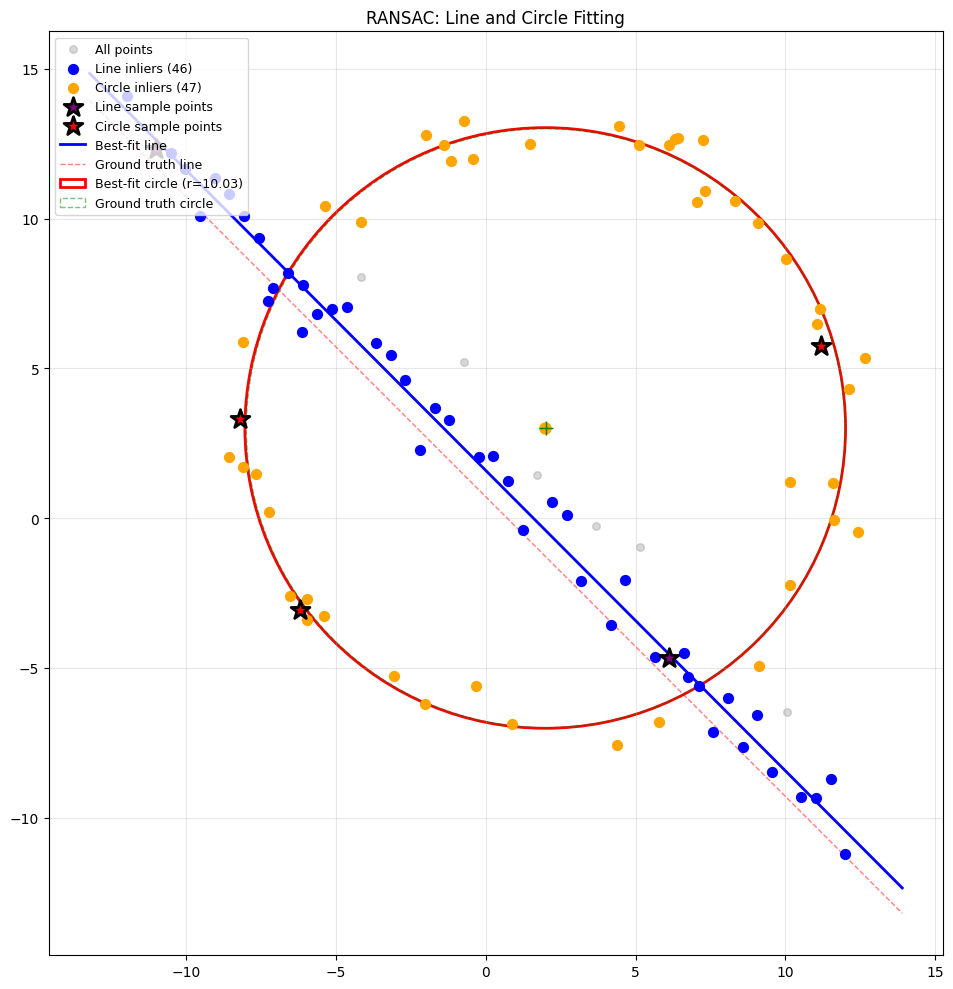


(d) What happens if we fit the circle first?
If we fit the circle first, the line points would be included in the
circle fitting process as outliers. Since there are equal numbers of
line and circle points (50 each), RANSAC might struggle to identify
the circle correctly as it needs a consensus. The line points might
interfere with finding good circle inliers, especially if the line
passes through or near the circular region. The order matters because
we're removing inliers from the dataset after fitting the first shape.
Fitting the line first is better because:
- Lines require only 2 points vs 3 for circles (easier to sample)
- Line inliers are easier to identify with simple distance metrics
- After removing line points, the remaining data is cleane


In [8]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Generate data
np.random.seed(42)  # For reproducibility
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points


def fit_line_to_points(points):
    """
    Fit a line to points using Total Least Squares.
    Returns [a, b, d] where [a,b] is unit normal and d is distance from origin.
    """
    # Center the points
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    
    # SVD for total least squares
    U, S, Vt = np.linalg.svd(centered)
    
    # Normal vector is the last right singular vector
    normal = Vt[-1, :]
    a, b = normal
    
    # Ensure unit norm (should already be, but just to be sure)
    norm = np.sqrt(a**2 + b**2)
    a, b = a/norm, b/norm
    
    # Calculate d (perpendicular distance from origin)
    d = a * centroid[0] + b * centroid[1]
    
    return np.array([a, b, d])


def line_distance(points, line_params):
    """
    Calculate perpendicular distance from points to line.
    line_params: [a, b, d] where ax + by = d
    """
    a, b, d = line_params
    distances = np.abs(a * points[:, 0] + b * points[:, 1] - d)
    return distances


def ransac_line(points, n_iterations=1000, threshold=1.0, min_inliers=40):
    """
    RANSAC algorithm for line fitting.
    """
    best_inliers = []
    best_line = None
    best_sample = None
    
    for i in range(n_iterations):
        # Randomly sample 2 points
        sample_idx = np.random.choice(len(points), 2, replace=False)
        sample = points[sample_idx]
        
        # Fit line to sample
        line_params = fit_line_to_points(sample)
        
        # Calculate distances for all points
        distances = line_distance(points, line_params)
        
        # Find inliers
        inliers_idx = np.where(distances < threshold)[0]
        
        # Update best model if we have more inliers
        if len(inliers_idx) > len(best_inliers):
            best_inliers = inliers_idx
            best_line = line_params
            best_sample = sample_idx
    
    # Refit line using all inliers
    if len(best_inliers) >= min_inliers:
        best_line = fit_line_to_points(points[best_inliers])
    
    return best_line, best_inliers, best_sample


def fit_circle_to_points(points):
    """
    Fit a circle to points using optimization.
    Returns [x0, y0, r] - center and radius.
    """
    def objective(params):
        x0, y0, r = params
        distances = np.sqrt((points[:, 0] - x0)**2 + (points[:, 1] - y0)**2)
        residuals = distances - r
        return np.sum(residuals**2)
    
    # Initial guess: centroid and mean distance
    x0_init = np.mean(points[:, 0])
    y0_init = np.mean(points[:, 1])
    r_init = np.mean(np.sqrt((points[:, 0] - x0_init)**2 + (points[:, 1] - y0_init)**2))
    
    result = minimize(objective, [x0_init, y0_init, r_init], method='Nelder-Mead')
    return result.x


def circle_distance(points, circle_params):
    """
    Calculate radial distance from points to circle.
    circle_params: [x0, y0, r]
    """
    x0, y0, r = circle_params
    distances_to_center = np.sqrt((points[:, 0] - x0)**2 + (points[:, 1] - y0)**2)
    radial_errors = np.abs(distances_to_center - r)
    return radial_errors


def ransac_circle(points, n_iterations=1000, threshold=1.5, min_inliers=35):
    """
    RANSAC algorithm for circle fitting.
    """
    best_inliers = []
    best_circle = None
    best_sample = None
    
    for i in range(n_iterations):
        # Randomly sample 3 points
        sample_idx = np.random.choice(len(points), 3, replace=False)
        sample = points[sample_idx]
        
        # Fit circle to sample
        try:
            circle_params = fit_circle_to_points(sample)
            
            # Check if radius is reasonable (positive and not too large)
            if circle_params[2] <= 0 or circle_params[2] > 50:
                continue
            
            # Calculate distances for all points
            distances = circle_distance(points, circle_params)
            
            # Find inliers
            inliers_idx = np.where(distances < threshold)[0]
            
            # Update best model if we have more inliers
            if len(inliers_idx) > len(best_inliers):
                best_inliers = inliers_idx
                best_circle = circle_params
                best_sample = sample_idx
        except:
            continue
    
    # Refit circle using all inliers
    if len(best_inliers) >= min_inliers:
        best_circle = fit_circle_to_points(points[best_inliers])
    
    return best_circle, best_inliers, best_sample


# (a) Fit line using RANSAC
print("Fitting line using RANSAC...")
line_params, line_inliers, line_sample = ransac_line(X, n_iterations=1000, threshold=1.0, min_inliers=20)
print(f"Line parameters [a, b, d]: {line_params}")
print(f"Number of line inliers: {len(line_inliers)}")

# (b) Remove line inliers and fit circle
print("\nFitting circle using RANSAC...")
remaining_points = np.delete(X, line_inliers, axis=0)
circle_params, circle_inliers_relative, circle_sample_relative = ransac_circle(
    remaining_points, n_iterations=1000, threshold=1.5, min_inliers=35
)
print(f"Circle parameters [x0, y0, r]: {circle_params}")
print(f"Number of circle inliers: {len(circle_inliers_relative)}")

# (c) Visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot all points
ax.scatter(X[:, 0], X[:, 1], c='gray', alpha=0.3, s=30, label='All points')

# Plot line inliers
ax.scatter(X[line_inliers, 0], X[line_inliers, 1], c='blue', s=50, 
           label=f'Line inliers ({len(line_inliers)})', zorder=3)

# Plot circle inliers (in original X coordinates)
circle_inliers_mask = np.ones(len(X), dtype=bool)
circle_inliers_mask[line_inliers] = False
circle_inliers_global = np.where(circle_inliers_mask)[0][circle_inliers_relative]
ax.scatter(X[circle_inliers_global, 0], X[circle_inliers_global, 1], c='orange', s=50,
           label=f'Circle inliers ({len(circle_inliers_relative)})', zorder=3)

# Plot line sample points
ax.scatter(X[line_sample, 0], X[line_sample, 1], c='purple', s=200, marker='*',
           edgecolors='black', linewidths=2, label='Line sample points', zorder=5)

# Plot circle sample points
circle_sample_global = np.where(circle_inliers_mask)[0][circle_sample_relative]
ax.scatter(X[circle_sample_global, 0], X[circle_sample_global, 1], c='red', s=200,
           marker='*', edgecolors='black', linewidths=2, label='Circle sample points', zorder=5)

# Draw best-fit line
a, b, d = line_params
x_min, x_max = ax.get_xlim()
if abs(b) > 1e-6:  # Line is not vertical
    x_line = np.array([x_min, x_max])
    y_line = (d - a * x_line) / b
else:  # Vertical line
    x_line = np.array([d/a, d/a])
    y_line = np.array([ax.get_ylim()[0], ax.get_ylim()[1]])
ax.plot(x_line, y_line, 'b-', linewidth=2, label='Best-fit line')

# Draw ground truth line
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
ax.plot(x_, y_, 'r--', linewidth=1, alpha=0.5, label='Ground truth line')

# Draw best-fit circle
x0, y0, r_fit = circle_params
circle_fit = plt.Circle((x0, y0), r_fit, color='red', fill=False, linewidth=2,
                         label=f'Best-fit circle (r={r_fit:.2f})')
ax.add_patch(circle_fit)
ax.plot(x0, y0, 'o', color='orange', markersize=8)

# Draw ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='green', fill=False, linewidth=1,
                        linestyle='--', alpha=0.5, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='green', markersize=10)

ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=9)
ax.set_title('RANSAC: Line and Circle Fitting')
plt.tight_layout()
plt.show()

# (d) Answer the question
print("\n(d) What happens if we fit the circle first?")
print("If we fit the circle first, the line points would be included in the")
print("circle fitting process as outliers. Since there are equal numbers of")
print("line and circle points (50 each), RANSAC might struggle to identify")
print("the circle correctly as it needs a consensus. The line points might")
print("interfere with finding good circle inliers, especially if the line")
print("passes through or near the circular region. The order matters because")
print("we're removing inliers from the dataset after fitting the first shape.")
print("Fitting the line first is better because:")
print("- Lines require only 2 points vs 3 for circles (easier to sample)")
print("- Line inliers are easier to identify with simple distance metrics")
print("- After removing line points, the remaining data is cleane")